# Analysis for XXX

*anonymous for peer review*


## Setting up

First we will load the libraries we'll need and setup a few boilerplate things to make figures pretty, etc. I'll also print the session info so people can see what the analysis environment was like. Note that I did this anyalysis in Google Colab via an R Kernel.

In [ ]:
# install packages
install.packages(c('lmerTest', 'infotheo'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘lme4’, ‘numDeriv’


Warning message in install.packages(c("lmerTest", "infotheo")):
“installation of package ‘nloptr’ had non-zero exit status”
Warning message in install.packages(c("lmerTest", "infotheo")):
“installation of package ‘lme4’ had non-zero exit status”
Warning message in install.packages(c("lmerTest", "infotheo")):
“installation of package ‘lmerTest’ had non-zero exit status”


In [ ]:
# load the tidyverse, but be quiet about it
options(tidyverse.quiet = TRUE)
library(tidyverse)

# load other libraries we'll need
library(lmerTest)     # for mixed effects models
library(infotheo)     # for entropy analysis

# turn off annoying "summarise()" warning in new dplyr
options(dplyr.summarise.inform = FALSE)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [ ]:
# print session info so we can see computing evironment
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_0.5.0     digest_0.6.29   utf8_1.2.2      crayon_1.4.2   
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.1 jsonlite_1.7.2 
 [9] evaluate_0.14   pillar_1.6.4    rlang_0.4.12    uuid_1.0-3     
[13] vctrs_0.3.8     ellipsis_0.3.2  IRkernel

In [ ]:
# set the theme and base size of figures
theme_set(theme_classic(base_size = 20))

# build simple coding matricies for mixed effects models
# for two levels
c2 <- contr.treatment(2)
coding2 <- matrix(rep(1/2, 2), ncol = 1)
simple2 <- c2-coding2

# for three levels
c3 <- contr.treatment(3)
coding3 <- matrix(rep(1/3, 6), ncol = 2)
simple3 <- c3-coding3

In [ ]:
# load the data
data <- read.csv('data_anonymized.csv')

## Experiment 1

### Participants

Get all of the participants in experiment 1

In [ ]:
participants <- data %>%
    filter(experiment %in% c("Experiment 1", "Experiment 2")) %>%
    mutate(condition = factor(condition, levels = c("Optional", "Alternating", "Alternating (sas)", "Optional Frequent", "Optional Rare")))%>%
    group_by(experiment, condition) %>%
    summarise(n = n_distinct(random_id))

participants %>%
    filter(experiment == "Experiment 1")

experiment,condition,n
<chr>,<fct>,<int>
Experiment 1,Optional,20
Experiment 1,Alternating,21
Experiment 1,Alternating (sas),20


In [ ]:
# get all proportion correct during exposure phase
attention_check <- data %>%
    filter(experiment %in% c("Experiment 1", "Experiment 2")) %>%
    filter(exp_phase == "exposure") %>%
    mutate(correct = ifelse(marker == whichPressed, 1, 0),
           condition = factor(condition, levels = c("Optional", "Alternating", "Alternating (sas)", "Optional Frequent", "Optional Rare")))%>%
    group_by(experiment, condition, random_id) %>%
    summarise(n = n(), ncorr = sum(correct), proportion = ncorr/n*100)

# summarise these results in a table
attention_check %>%
    filter(experiment == "Experiment 1") %>%
    group_by(condition) %>%
    summarise(n = n(), mean = mean(proportion), sd = sd(proportion), min = min(proportion), max = max(proportion))

condition,n,mean,sd,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Optional,20,99.37500,0.7089136,98.61111,100
Alternating,21,99.40476,0.7042952,98.61111,100
Alternating (sas),20,99.16667,2.0352642,91.66667,100


### Results

Next we'll analyze the production test. We want to know whether participants regularize more in some conditions than others. We've hypothesized that participants in the alternating conditions should regularize more than those in the optional condition.


#### Use of dominant form

One way to test this is to simply ask whether participants in the alternating conditions use the dominant form than those in the optional one.

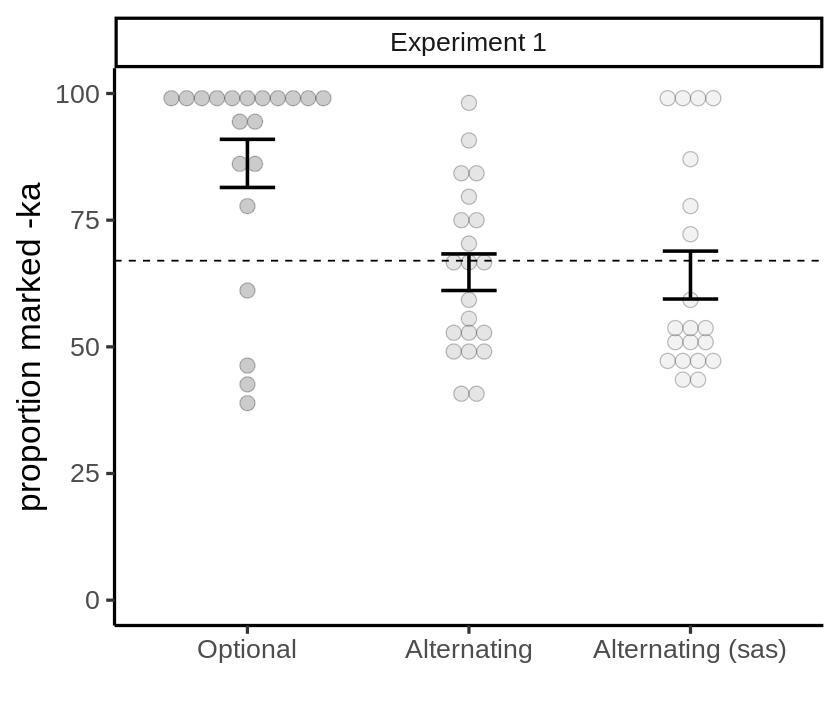

In [ ]:
#set figure size
options(repr.plot.width=7, repr.plot.height=6)

# first let's get use of the dominant form by participant in Experiment 1
use_dominant <- data %>%
    filter(experiment == "Experiment 1") %>%
    filter(exp_phase == "production") %>%
    mutate(condition = factor(condition, levels = c("Optional", "Alternating", "Alternating (sas)")))%>%
    group_by(experiment, condition, random_id) %>%
    summarise(n = n(), nKa = sum(isKa), proportion = nKa/n*100)

# and then generate a figure from that for the paper
use_dominant %>%
    ggplot(aes(condition, proportion, fill = condition)) +
    facet_grid(.~experiment)+
    geom_dotplot(binaxis = "y", stackdir = "center", alpha = 0.25, binwidth = 3) +
    stat_summary(fun.data = "mean_se", geom = "errorbar", width = 0.25, size = 1) +
    geom_hline(yintercept = 67, linetype = "dashed") +
    theme(legend.position = "None") +
    labs(x = "", y = "proportion marked -ka") +
    ylim(c(0,100)) +
    scale_fill_grey()

What we can see from the figure is the exact oposite of what we predicted: participants in the optional language regularize more. Let's get some stats to support this.

In [ ]:
# get the data we'll use for the model
model_data_exp1 <- data %>%
    filter(experiment == "Experiment 1", exp_phase == "production") %>%
    mutate(condition = factor(condition, levels = c("Optional", "Alternating", "Alternating (sas)")))

# and apply simple coding to our fixed effect of condition
contrasts(model_data_exp1$condition) <- simple3

Next let's determine the best fitting random effects structure. Here we'll only add complexity to the model when doing so contributes to fit.

In [ ]:
# build the null model, with random intercepts and slopes for participants
exp1.null <- glmer(
              isKa ~ 1 + (1|random_id),
              family = "binomial",
              data = filter(model_data_exp1),
              control=glmerControl(optimizer="bobyqa"))

# add a random intercepts for objects
exp1.obj <- update(exp1.null, .~ 1 + (1 | random_id) + (1 | meaning))

# random intercepts and slopes for objects
exp1.objcond <- update(exp1.obj, .~ 1 + (1 | random_id) + (condition | meaning))

# test if model fit is improved by adding complexity
anova(exp1.null, exp1.obj, exp1.objcond)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
exp1.null,2,3239.732,3251.932,-1617.866,3235.732,NA,NA,NA
exp1.obj,3,3090.543,3108.842,-1542.271,3084.543,151.18889,1,9.530237e-35
exp1.objcond,8,3064.814,3113.613,-1524.407,3048.814,35.72857,5,1.076254e-06


The model fit is significantly improved when we allow the effect of noun to vary by participant, so we'll use that as our random effects structure. Next let's build the model incrementally to test for main effects.

In [ ]:
# incrementally build up models to test for main effects
exp1.cond <- update(exp1.obj, .~. + condition)

# and then test for main effects
anova(exp1.obj, exp1.cond)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
exp1.obj,3,3090.543,3108.842,-1542.271,3084.543,NA,NA,NA
exp1.cond,5,3073.982,3104.481,-1531.991,3063.982,20.56104,2,3.429474e-05


As we saw in the figure, there is a main effect of condition, indicating that use of the dominant form is predicted by condition. Let's get the model coefficients to see how much log-odds change by condition.

In [ ]:
# show model coefficients in a table
summary(exp1.cond)$coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),1.713099,0.3405760,5.030005,4.904664e-07
condition2,-2.488066,0.5686385,-4.375479,1.211663e-05
condition3,-2.258778,0.5747481,-3.930031,8.493498e-05


Great, so this is telling us that participants in the alternating condition actually have signficantly lower (-2.49) odds of using the dominant form than participants in the optional condition (our reference level). Participants in the alternating same as singular condition also have signficantly lower (-2.26) odds than optional. I don't really think it's worth releveling the model to compare optional directly to alternating same as singular, so I'm not going to do that here.

#### Entropy

We've determined that participants in the optional condition actually use the dominant form most, but we havent' statistically addressed the regularization question. For that we can use entropy. First we'll calculate mentropy and mutual information (by noun and animacy) for both experiments so we have those values to work with.

In [ ]:
# get entropy and mi for both experiments
entropy_byparticipant <- data %>%
    filter(experiment %in% c("Experiment 1", "Experiment 2"), exp_phase == "production") %>%
    group_by(experiment, condition, random_id) %>%
    mutate(animate = ifelse(meaning %in% c("sheep", "cow", "pig"), "animate", "inanimate")) %>%
    summarise(n = n(), ent = entropy(whichPressed),
              cond.noun = condentropy(whichPressed, noun),
              mi.noun = ent-cond.noun,
              cond.animacy = condentropy(whichPressed, animate),
              mi.animacy = ent-cond.animacy) %>%
    gather(key = "kind_ent", value = "ent", ent:mi.animacy)

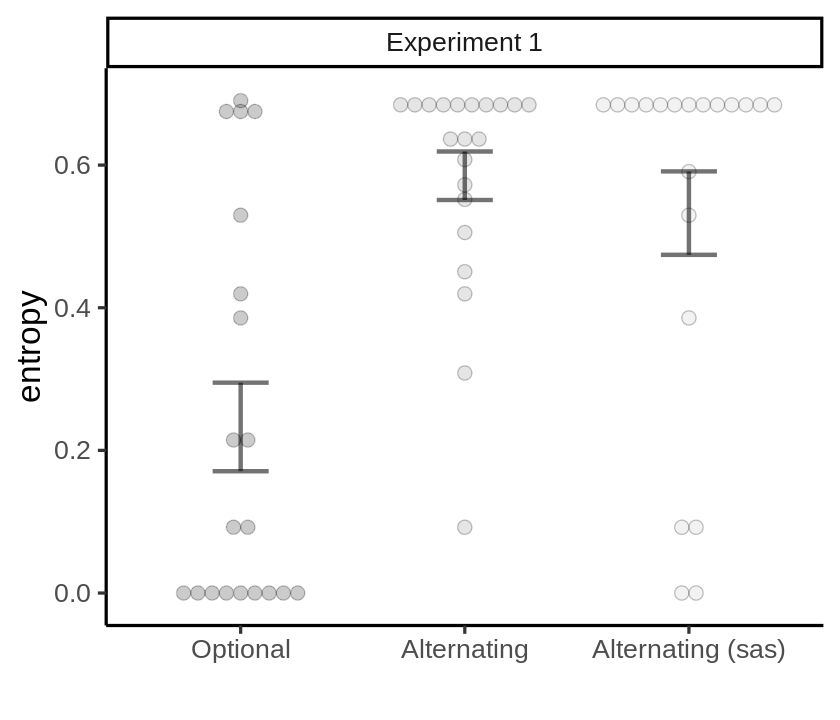

In [ ]:
#set figure size
options(repr.plot.width=7, repr.plot.height=6)

entropy_byparticipant  %>%
    filter(experiment == "Experiment 1", kind_ent == "ent") %>%
    mutate(condition = factor(condition,
                              levels = c("Optional", "Alternating", "Alternating (sas)", "Optional Frequent", "Optional Rare")),
           kind_ent = factor(kind_ent, labels = c("Entropy"))) %>%
    ggplot(aes(condition, ent, fill = condition, alpha = 0.75)) +
    facet_grid(.~experiment, scales = "free", space = "free")+
     #stat_summary(fun = "mean", geom = "bar", width = 0.5, color = "black", alpha = 0.75) +
    geom_dotplot(binaxis = "y", stackdir = "center", alpha = 0.25, binwidth = 0.02) +
    #stat_summary(fun = "mean", geom = "point", size = 2) +
    stat_summary(fun.data = "mean_se", geom = "errorbar", width = 0.25, size = 1.25) +
    theme(legend.position = "None") +
    labs(x = "", y = "entropy")  +
    scale_fill_grey()

In [ ]:
# get the data we'll use for the model
model_data_exp1_ent <- entropy_byparticipant %>%
    filter(experiment == "Experiment 1", kind_ent == "ent") %>%
    mutate(condition = factor(condition, levels = c("Optional", "Alternating", "Alternating (sas)")))

# and apply simple coding to our fixed effect of condition
contrasts(model_data_exp1_ent$condition) <- simple3

In [ ]:
# build the null model
exp1ent.null <- lm(
              ent ~ 1,
              data = model_data_exp1_ent)

# predict entropy by condition
exp1ent.condition <- update(exp1ent.null, .~. + condition)

# test for main effect of condition
anova(exp1ent.null, exp1ent.condition)

# get model coefficients
summary(exp1ent.condition)$coefficients

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,60,4.712624,NA,NA,NA,NA
2,58,3.250292,2,1.462332,13.04732,2.094737e-05


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.4502038,0.03031776,14.849506,2.024433e-21
condition2,0.3521961,0.07396300,4.761787,1.321543e-05
condition3,0.2997974,0.07485955,4.004799,1.788562e-04


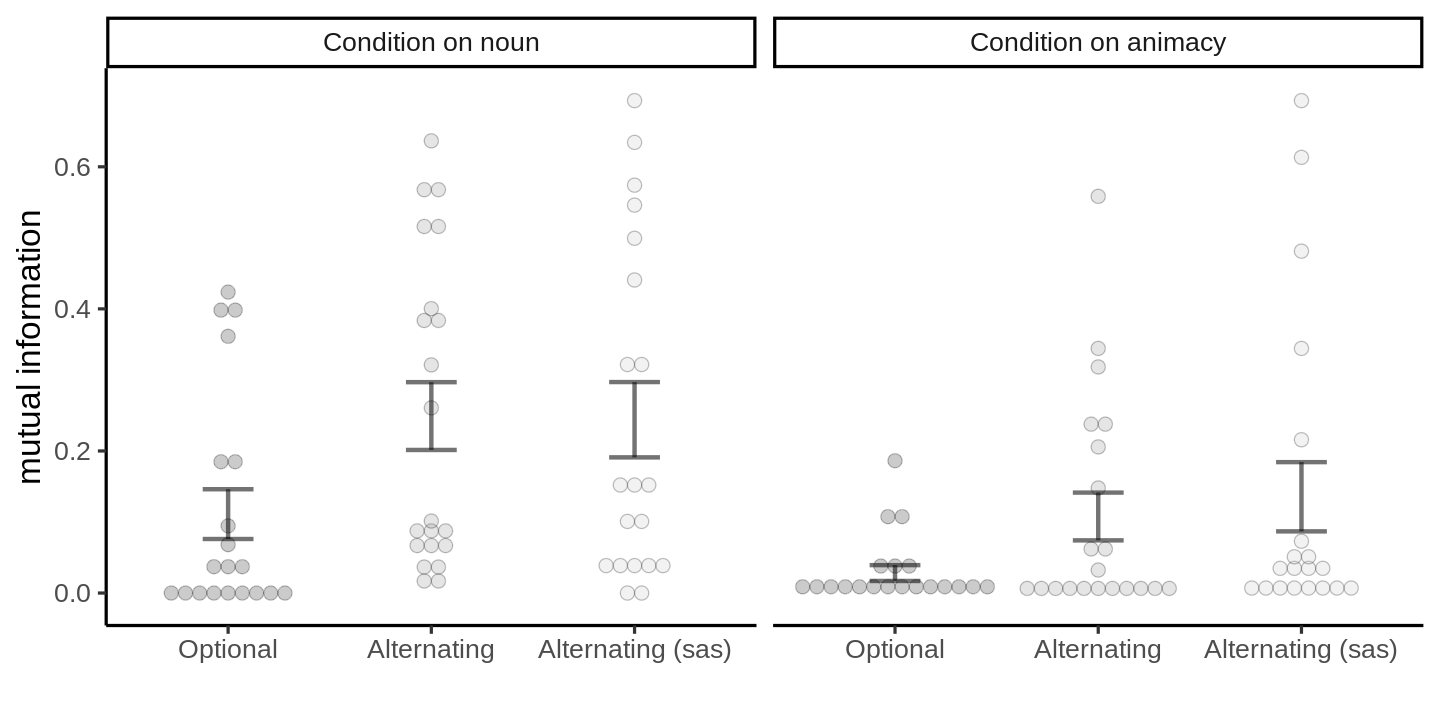

In [ ]:
#set figure size
options(repr.plot.width=12, repr.plot.height=6)

entropy_byparticipant  %>%
    filter(experiment == "Experiment 1", kind_ent %in% c("mi.noun", "mi.animacy")) %>%
    mutate(condition = factor(condition,
                              levels = c("Optional", "Alternating", "Alternating (sas)", "Optional Frequent", "Optional Rare")),
           kind_ent = factor(kind_ent,
                              levels = c("mi.noun", "mi.animacy"),
                              labels = c("Condition on noun", "Condition on animacy"))) %>%
    ggplot(aes(condition, ent, fill = condition, alpha = 0.75)) +
    facet_grid(.~kind_ent, scales = "free", space = "free")+
     #stat_summary(fun = "mean", geom = "bar", width = 0.5, color = "black", alpha = 0.75) +
    geom_dotplot(binaxis = "y", stackdir = "center", alpha = 0.25, binwidth = 0.02) +
    #stat_summary(fun = "mean", geom = "point", size = 2) +
    stat_summary(fun.data = "mean_se", geom = "errorbar", width = 0.25, size = 1.25) +
    theme(legend.position = "None") +
    labs(x = "", y = "mutual information")  +
    scale_fill_grey()

In [ ]:
# get the data we'll use for the model
model_data_exp1_mi <- entropy_byparticipant %>%
    filter(experiment == "Experiment 1", kind_ent %in% c("mi.noun", "mi.animacy")) %>%
    mutate(condition = factor(condition, levels = c("Optional", "Alternating", "Alternating (sas)")))

# and apply simple coding to our fixed effect of condition
contrasts(model_data_exp1_mi$condition) <- simple3

In [ ]:
# build the null model
exp1mi.null <- lmer(
              ent ~ 1 + (1|random_id),
              data = filter(model_data_exp1_mi))

# predict entropy by condition
exp1mi.condition <- update(exp1mi.null, .~. + condition)
exp1mi.kind_ent <- update(exp1mi.condition, .~. + kind_ent)
exp1mi.interaction <- update(exp1mi.kind_ent, .~. + condition:kind_ent)

# test for main effect of condition
anova(exp1mi.null, exp1mi.condition, exp1mi.kind_ent, exp1mi.interaction)

# get model coefficients
summary(exp1mi.interaction)$coefficients

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
exp1mi.null,3,-69.84006,-61.42800,37.92003,-75.84006,NA,NA,NA
exp1mi.condition,5,-72.04964,-58.02954,41.02482,-82.04964,6.209579,2,4.483396e-02
exp1mi.kind_ent,6,-98.86549,-82.04137,55.43275,-110.86549,28.815852,1,7.959694e-08
exp1mi.interaction,8,-96.60002,-74.16786,56.30001,-112.60002,1.734530,2,4.200989e-01


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),0.09048164,0.02352544,78.6879,3.8461183,2.423500e-04
condition2,0.07964798,0.05739250,78.6879,1.3877768,1.691223e-01
condition3,0.10740009,0.05808820,78.6879,1.8489142,6.822608e-02
kind_entmi.noun,0.11091458,0.01856555,58.0000,5.9742146,1.503093e-07
condition2:kind_entmi.noun,0.05836155,0.04529238,58.0000,1.2885511,2.026706e-01
condition3:kind_entmi.noun,0.02546616,0.04584140,58.0000,0.5555275,5.806704e-01


## Experiment 2

### Participants

Get all of the participants in experiment 2

In [ ]:
participants %>%
    filter(experiment == "Experiment 2")

experiment,condition,n
<chr>,<fct>,<int>
Experiment 2,Optional Frequent,20
Experiment 2,Optional Rare,20


In [ ]:
# get the results of the attention check
attention_check %>%
    filter(experiment == "Experiment 2") %>%
    group_by(condition) %>%
    summarise(n = n(), mean = mean(proportion), sd = sd(proportion), min = min(proportion), max = max(proportion))

condition,n,mean,sd,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Optional Frequent,20,97.91667,2.795993,88.88889,100
Optional Rare,20,96.59722,11.069687,50.00000,100


In [ ]:
# note that the min is 50%, indiciating at least one person failed the attention check.
# let's exclude those who fail the attention check (85%) and try again.
attention_check %>%
    filter(experiment == "Experiment 2") %>%
    filter(proportion > 85) %>%
    group_by(condition) %>%
    summarise(n = n(), mean = mean(proportion), sd = sd(proportion), min = min(proportion), max = max(proportion))


condition,n,mean,sd,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Optional Frequent,20,97.91667,2.795993,88.88889,100
Optional Rare,19,99.04971,1.539143,95.83333,100


In [ ]:
attention_check %>%
  filter(experiment == "Experiment 2") %>%
  filter(proportion < 85) %>%
  group_by(random_id)

experiment,condition,random_id,n,ncorr,proportion
<chr>,<fct>,<chr>,<int>,<dbl>,<dbl>
Experiment 2,Optional Rare,oocgzcqvrcc4,72,36,50


### Results

Next we'll analyze the production test. We want to know whether participants regularize more in some conditions than others. We've hypothesized that participants in the optional rare condition should regularize less.


#### Use of dominant form

One way to test this is to simply ask whether participants use the dominant form more.

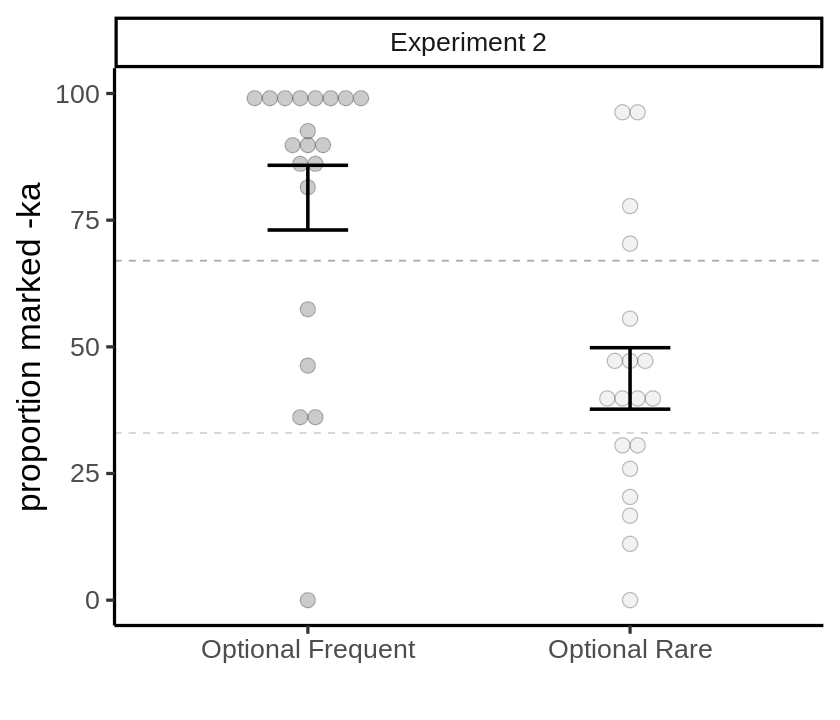

In [ ]:
#set figure size
options(repr.plot.width=7, repr.plot.height=6)

# first let's get use of the dominant form by participant in Experiment 2
use_dominant <- data %>%
    filter(experiment == "Experiment 2") %>%
    filter(exp_phase == "production") %>%
    filter(random_id != "oocgzcqvrcc4") %>%
    mutate(condition = factor(condition))%>%
    group_by(experiment, condition, random_id) %>%
    summarise(n = n(), nKa = sum(isKa), proportion = nKa/n*100)

# and then generate a figure from that for the paper
use_dominant %>%
    ggplot(aes(condition, proportion, fill = condition)) +
    facet_grid(.~experiment)+
    geom_dotplot(binaxis = "y", stackdir = "center", alpha = 0.25, binwidth = 3) +
    stat_summary(fun.data = "mean_se", geom = "errorbar", width = 0.25, size = 1) +
    geom_hline(yintercept = 67, linetype = "dashed", color = "dark gray") +
    geom_hline(yintercept = 33, linetype = "dashed", color = "light gray") +
    theme(legend.position = "None") +
    labs(x = "", y = "proportion marked -ka") +
    ylim(c(0,100)) +
    scale_fill_grey()

What we can see from the figure is as predicted. let's get some stats.

In [ ]:
# get the data we'll use for the model
model_data_exp2 <- data %>%
    filter(random_id != "oocgzcqvrcc4") %>%
    filter(experiment == "Experiment 2", exp_phase == "production") %>%
    mutate(condition = factor(condition))

# and apply simple coding to our fixed effect of condition
contrasts(model_data_exp2$condition) <- simple2

Next let's determine the best fitting random effects structure. Here we'll only add complexity to the model when doing so contributes to fit.

In [ ]:
# build the null model, with random intercepts and slopes for participants
exp2.null <- glmer(
              isKa ~ 1 + (1|random_id),
              family = "binomial",
              data = filter(model_data_exp2),
              control=glmerControl(optimizer="bobyqa"))

# add a random intercepts for objects
exp2.obj <- update(exp2.null, .~ 1 + (1 | random_id) + (1 | meaning))

# random intercepts and slopes for objects
exp2.objcond <- update(exp2.obj, .~ 1 + (1 | random_id) + (condition | meaning))

# test if model fit is improved by adding complexity
anova(exp2.null, exp2.obj, exp2.objcond)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
exp2.null,2,1842.770,1854.075,-919.3852,1838.770,NA,NA,NA
exp2.obj,3,1840.788,1857.745,-917.3938,1834.788,3.982834,1,0.04596617
exp2.objcond,5,1840.164,1868.427,-915.0819,1830.164,4.623689,2,0.09907836


The model fit is significantly improved when we allow the effect of noun to vary by participant, so we'll use that as our random effects structure. Next let's build the model incrementally to test for main effects.

In [ ]:
# incrementally build up models to test for main effects
exp2.cond <- update(exp2.obj, .~. + condition)

# and then test for main effects
anova(exp2.obj, exp2.cond)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
exp2.obj,3,1840.788,1857.745,-917.3938,1834.788,NA,NA,NA
exp2.cond,4,1830.465,1853.075,-911.2325,1822.465,12.32247,1,0.0004475383


As we saw in the figure, there is a main effect of condition, indicating that use of the dominant form is predicted by condition. Let's get the model coefficients to see how much log-odds change by condition.

In [ ]:
# show model coefficients in a table
summary(exp2.cond)$coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),1.086977,0.3808262,2.854260,0.004313717
condition2,-2.798979,0.7457291,-3.753346,0.000174490


Great, so this is telling us that participants in the alternating condition actually have signficantly lower (-2.49) odds of using the dominant form than participants in the optional condition (our reference level). Participants in the alternating same as singular condition also have signficantly lower (-2.26) odds than optional. I don't really think it's worth releveling the model to compare optional directly to alternating same as singular, so I'm not going to do that here.

#### Entropy

We've determined that participants in the optional condition actually use the dominant form most, but we havent' statistically addressed the regularization question. For that we can use entropy. First we'll calculate mentropy and mutual information (by noun and animacy) for both experiments so we have those values to work with.

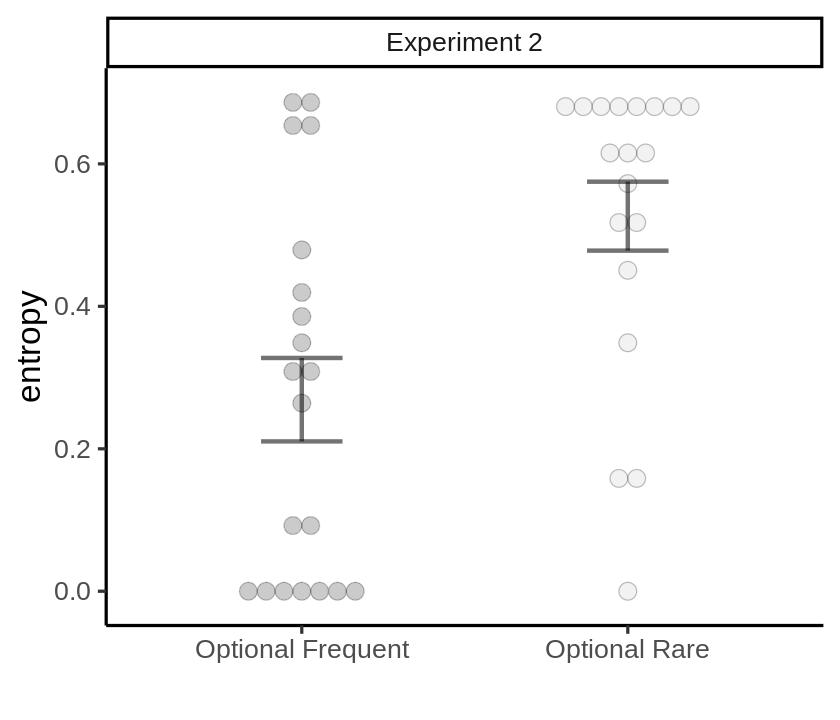

In [ ]:
#set figure size
options(repr.plot.width=7, repr.plot.height=6)

entropy_byparticipant  %>%
    filter(random_id != "oocgzcqvrcc4") %>%
    filter(experiment == "Experiment 2", kind_ent == "ent") %>%
    mutate(condition = factor(condition),
           kind_ent = factor(kind_ent, labels = c("Entropy"))) %>%
    ggplot(aes(condition, ent, fill = condition, alpha = 0.75)) +
    facet_grid(.~experiment, scales = "free", space = "free")+
     #stat_summary(fun = "mean", geom = "bar", width = 0.5, color = "black", alpha = 0.75) +
    geom_dotplot(binaxis = "y", stackdir = "center", alpha = 0.25, binwidth = 0.025) +
    #stat_summary(fun = "mean", geom = "point", size = 2) +
    stat_summary(fun.data = "mean_se", geom = "errorbar", width = 0.25, size = 1.25) +
    theme(legend.position = "None") +
    labs(x = "", y = "entropy")  +
    scale_fill_grey()

In [ ]:
# get the data we'll use for the model
model_data_exp2_ent <- entropy_byparticipant %>%
    filter(random_id != "oocgzcqvrcc4") %>%
    filter(experiment == "Experiment 2", kind_ent == "ent") %>%
    mutate(condition = factor(condition))

# and apply simple coding to our fixed effect of condition
contrasts(model_data_exp2_ent$condition) <- simple2

In [ ]:
# build the null model
exp2ent.null <- lm(
              ent ~ 1,
              data = model_data_exp2_ent)

# predict entropy by condition
exp2ent.condition <- update(exp2ent.null, .~. + condition)

# test for main effect of condition
anova(exp2ent.null, exp2ent.condition)

# get model coefficients
summary(exp2ent.condition)$coefficients

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,38,2.751084,NA,NA,NA,NA
2,37,2.104376,1,0.6467077,11.37068,0.001759389


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.3977599,0.03820070,10.412372,1.507518e-12
condition2,0.2576289,0.07640141,3.372043,1.759389e-03


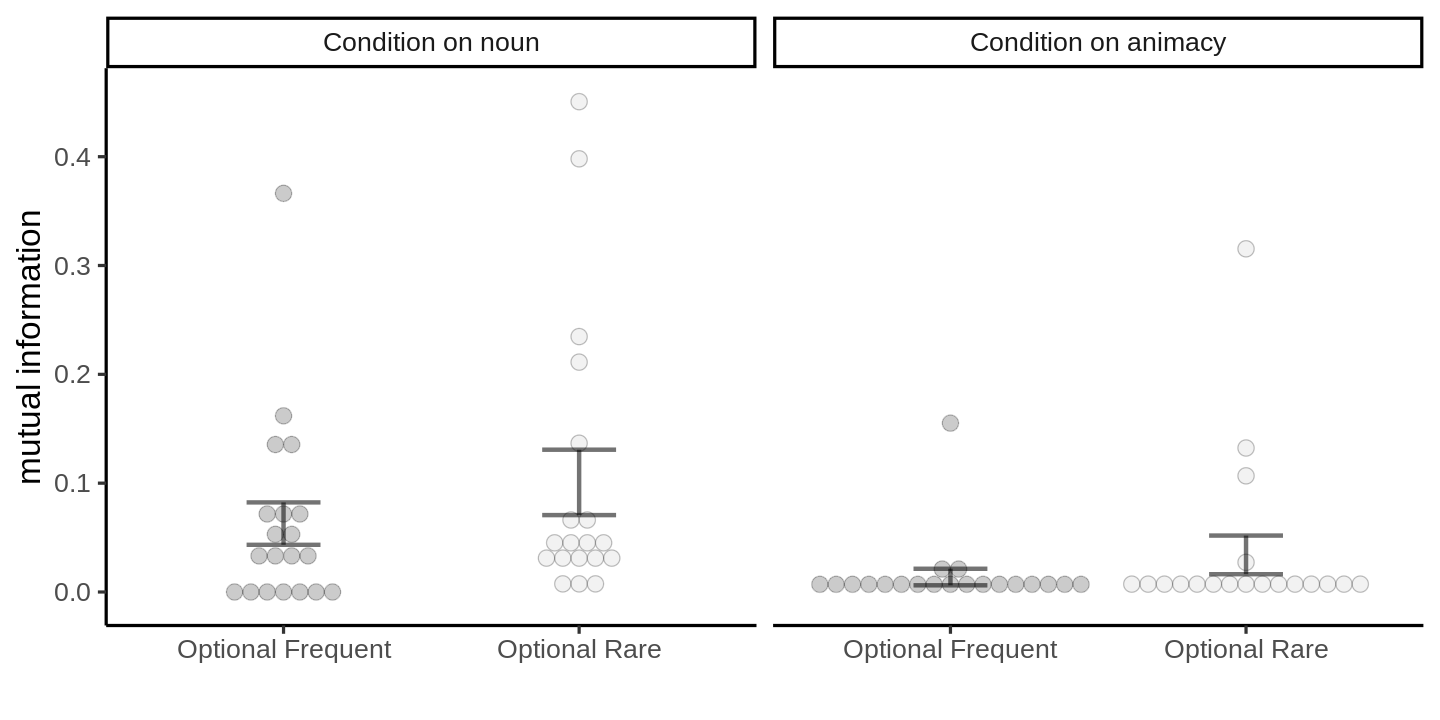

In [ ]:
#set figure size
options(repr.plot.width=12, repr.plot.height=6)

entropy_byparticipant  %>%
      filter(random_id != "oocgzcqvrcc4") %>%
    filter(experiment == "Experiment 2", kind_ent %in% c("mi.noun", "mi.animacy")) %>%
    mutate(condition = factor(condition),
           kind_ent = factor(kind_ent,
                              levels = c("mi.noun", "mi.animacy"),
                              labels = c("Condition on noun", "Condition on animacy"))) %>%
    ggplot(aes(condition, ent, fill = condition, alpha = 0.75)) +
    facet_grid(.~kind_ent, scales = "free", space = "free")+
     #stat_summary(fun = "mean", geom = "bar", width = 0.5, color = "black", alpha = 0.75) +
    geom_dotplot(binaxis = "y", stackdir = "center", alpha = 0.25, binwidth = 0.015) +
    #stat_summary(fun = "mean", geom = "point", size = 2) +
    stat_summary(fun.data = "mean_se", geom = "errorbar", width = 0.25, size = 1.25) +
    theme(legend.position = "None") +
    labs(x = "", y = "mutual information")  +
    scale_fill_grey()

In [ ]:
# get the data we'll use for the model
model_data_exp2_mi <- entropy_byparticipant %>%
    filter(random_id != "oocgzcqvrcc4") %>%
    filter(experiment == "Experiment 2", kind_ent %in% c("mi.noun", "mi.animacy")) %>%
    mutate(condition = factor(condition))

# and apply simple coding to our fixed effect of condition
contrasts(model_data_exp2_mi$condition) <- simple2

In [ ]:
# build the null model
exp2mi.null <- lmer(
              ent ~ 1 + (1|random_id),
              data = filter(model_data_exp2_mi))

# predict entropy by condition
exp2mi.condition <- update(exp2mi.null, .~. + condition)
exp2mi.kind_ent <- update(exp2mi.condition, .~. + kind_ent)
exp2mi.interaction <- update(exp2mi.kind_ent, .~. + condition:kind_ent)

# test for main effect of condition
anova(exp2mi.null, exp2mi.condition, exp2mi.kind_ent, exp2mi.interaction)

# get model coefficients
summary(exp2mi.interaction)$coefficients

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
exp2mi.null,3,-156.3852,-149.3151,81.19260,-162.3852,NA,NA,NA
exp2mi.condition,4,-155.6828,-146.2560,81.84142,-163.6828,1.2976382,1,2.546451e-01
exp2mi.kind_ent,5,-173.7939,-162.0104,91.89697,-183.7939,20.1111017,1,7.307130e-06
exp2mi.interaction,6,-172.4059,-158.2656,92.20293,-184.4059,0.6119168,1,4.340670e-01


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),0.02391378,0.01420939,50.8163,1.6829560,9.851868e-02
condition2,0.02034504,0.02841878,50.8163,0.7159013,4.773293e-01
kind_entmi.noun,0.05785793,0.01144813,37.0000,5.0539180,1.193974e-05
condition2:kind_entmi.noun,0.01751400,0.02289627,37.0000,0.7649279,4.491661e-01
